In [1]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt

from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Input
from keras.losses import MeanSquaredError
from keras.optimizers import Adam, RMSprop

In [2]:
dataset = pd.read_csv('../dataset/dados_pregao_tots3.csv')
colunas = ['data_pregao', 'preco_ultimo_negocio']
data = dataset[colunas].copy()

data['data_pregao'] = pd.to_datetime(data['data_pregao'])
data.set_index('data_pregao', inplace=True)

values = data['preco_ultimo_negocio'].values

train_values, test_values = train_test_split(values, test_size=0.2, shuffle=False)

In [3]:
sequence_length = None
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X_train, y_train = create_sequences(train_values, sequence_length)
X_test, y_test = create_sequences(test_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [4]:
def objective(trial):
    units = trial.suggest_int('units', 32, 128)  
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units, activation='relu'))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=MeanSquaredError())

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    val_loss = model.evaluate(X_test, y_test, verbose=0)
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

best_params = study.best_params
print(f"Melhores Hiperparâmetros: {best_params}")

best_model = Sequential()
best_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(LSTM(best_params['units'], activation='relu'))
best_model.add(Dense(1))

if best_params['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])

best_model.compile(optimizer=optimizer, loss=MeanSquaredError())

best_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

predictions = best_model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

dir = '../model/tots3_model.keras'
best_model.save(dir)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

[I 2024-10-24 10:40:58,590] A new study created in memory with name: no-name-bb60bb5b-5f53-4ab5-b179-9bdb85086480
[I 2024-10-24 10:41:56,751] Trial 0 finished with value: 0.32300254702568054 and parameters: {'units': 32, 'learning_rate': 0.0004097001231918961, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.32300254702568054.
[I 2024-10-24 10:43:12,066] Trial 1 finished with value: 0.4658537209033966 and parameters: {'units': 75, 'learning_rate': 4.43385926935866e-05, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.32300254702568054.
[I 2024-10-24 10:44:21,190] Trial 2 finished with value: 0.9967097640037537 and parameters: {'units': 96, 'learning_rate': 4.8995711229182666e-05, 'optimizer': 'adam'}. Best is trial 0 with value: 0.32300254702568054.
[I 2024-10-24 10:46:00,180] Trial 3 finished with value: 0.4866501986980438 and parameters: {'units': 126, 'learning_rate': 2.8244523692013738e-05, 'optimizer': 'adam'}. Best is trial 0 with value: 0.32300254702568054.
[I 2024-1

Melhores Hiperparâmetros: {'units': 32, 'learning_rate': 0.0004097001231918961, 'optimizer': 'rmsprop'}
Test Loss: 5.903774738311768
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Mean Squared Error (MSE): 17.490334672403524
Root Mean Squared Error (RMSE): 4.182144745510792
Mean Absolute Percentage Error (MAPE): 10.516062846532451%


COMPARATIVO COM OS ÚLTIMOS 30 DIAS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Mean Squared Error (MSE): 1.5673776218553188
Root Mean Squared Error (RMSE): 1.2519495284776134
Mean Absolute Percentage Error (MAPE): 3.495318717979503%


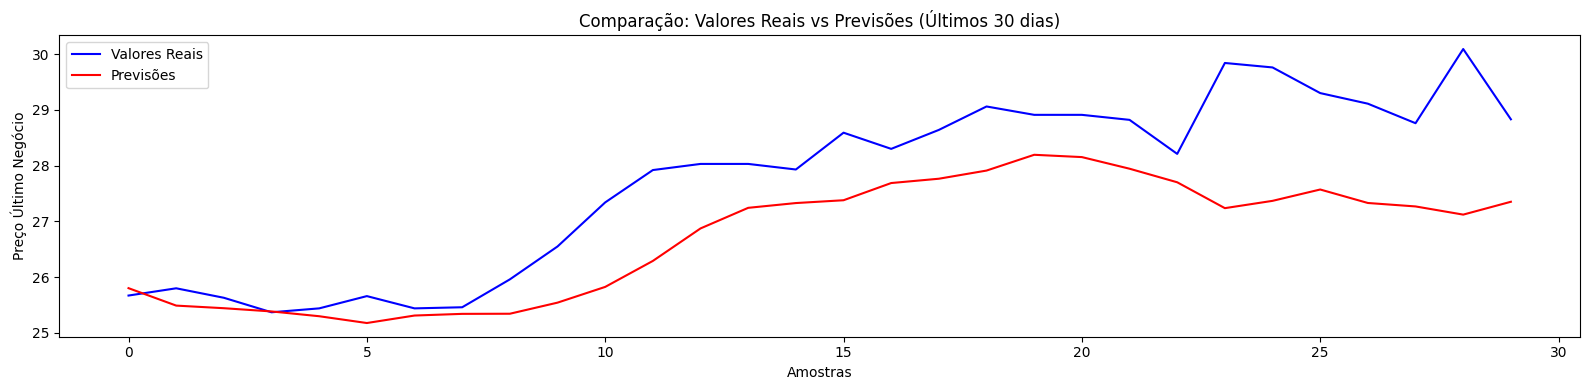

In [5]:
comparison_data = train_values[-60:]
X_test = comparison_data.reshape(-1, 1)

X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

predictions = best_model.predict(X_test_sequences)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 30 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

COMPARATIVO COM OS ÚLTIMOS 60 DIAS

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Mean Squared Error (MSE): 1.2492647709707532
Root Mean Squared Error (RMSE): 1.1177051359686745
Mean Absolute Percentage Error (MAPE): 3.147034596581464%


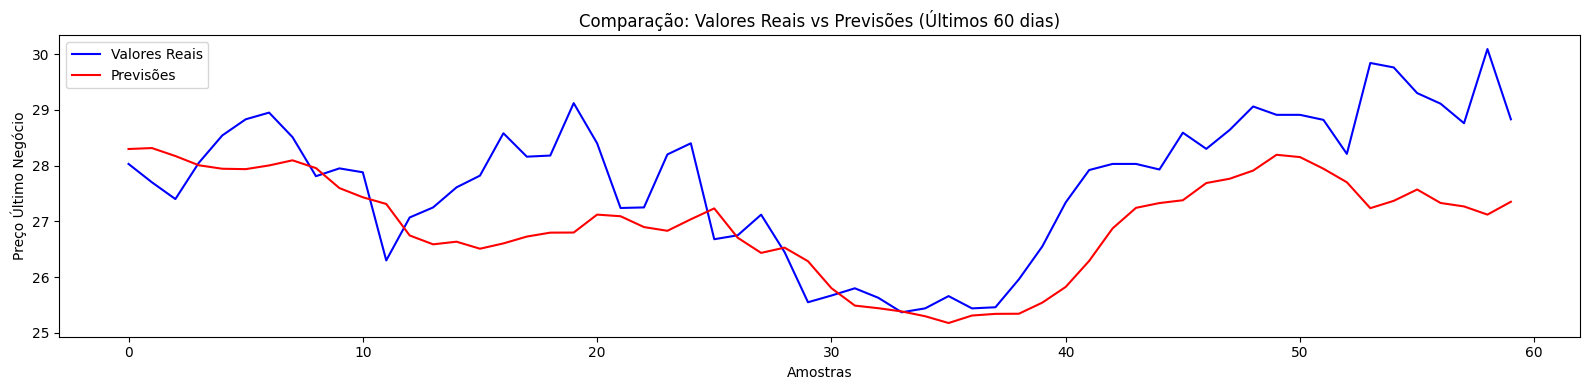

In [6]:
comparison_data = train_values[-90:]
X_test = comparison_data.reshape(-1, 1)

X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

predictions = best_model.predict(X_test_sequences)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 60 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

COMPARATIVO COM OS ÚLTIMOS 90 DIAS

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Mean Squared Error (MSE): 1.6258126565603175
Root Mean Squared Error (RMSE): 1.2750735886843227
Mean Absolute Percentage Error (MAPE): 3.6143593577211677%


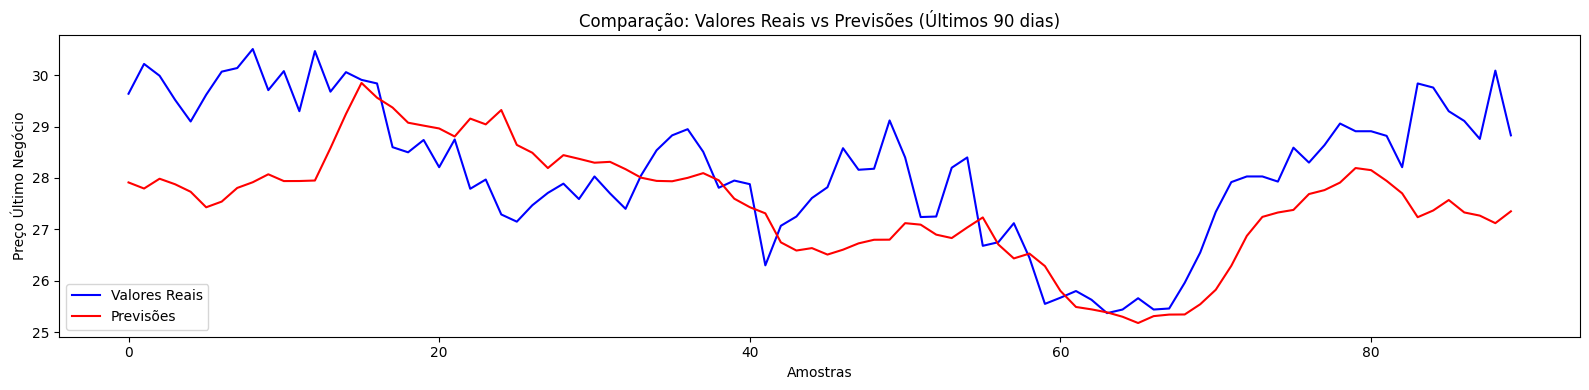

In [7]:
comparison_data = train_values[-120:]
X_test = comparison_data.reshape(-1, 1)

X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

predictions = best_model.predict(X_test_sequences)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 90 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

PREVISÃO PARA OS PRÓXIMOS 30 DIAS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

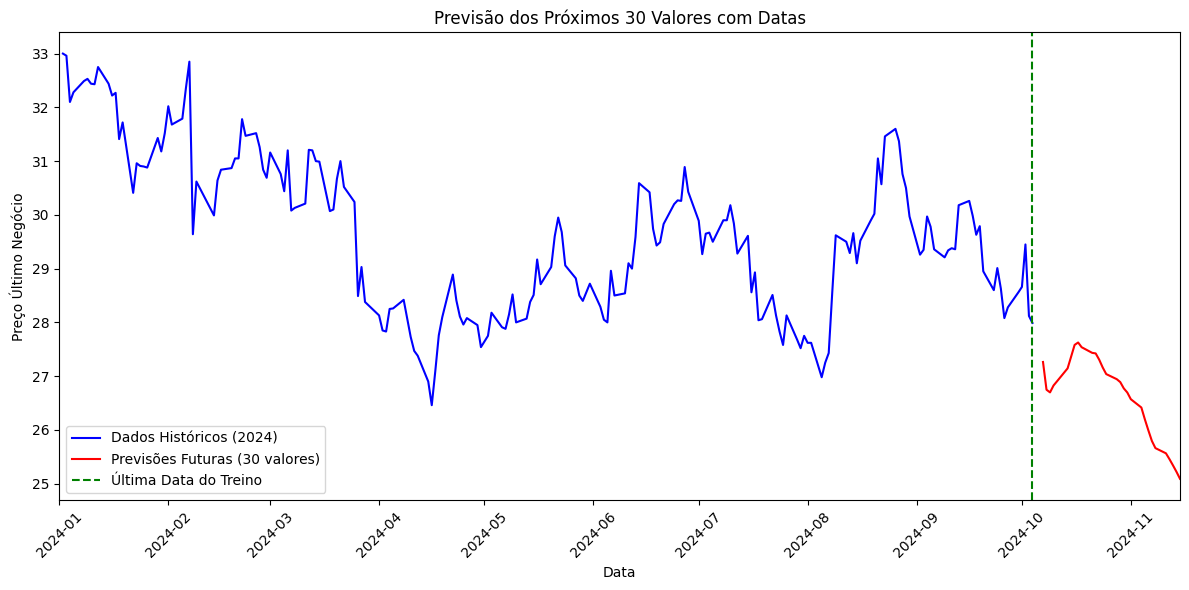

In [8]:
last_sequence = train_values[-sequence_length:]
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(30):
    next_prediction = best_model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

future_predictions = np.array(future_predictions).flatten()

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')

future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

plt.figure(figsize=(12, 6))

data_2024 = data[data.index >= '2024']

plt.plot(data_2024.index, data_2024['preco_ultimo_negocio'], label='Dados Históricos (2024)', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (30 valores)', color='red')

plt.xlim(pd.Timestamp('2024-01-01'), future_df['Date'].max())

plt.title('Previsão dos Próximos 30 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

PREVISÃO PARA OS PRÓXIMOS 60 DIAS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

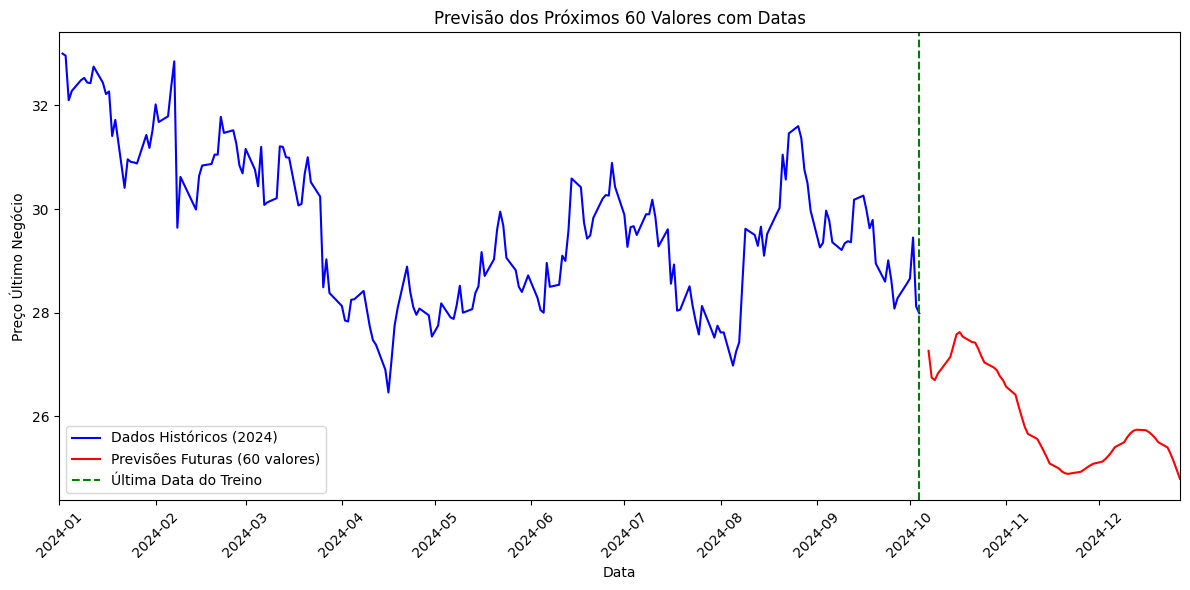

In [9]:
last_sequence = train_values[-sequence_length:]
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(60):
    next_prediction = best_model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

future_predictions = np.array(future_predictions).flatten()

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='B')

future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

plt.figure(figsize=(12, 6))

data_2024 = data[data.index >= '2024']

plt.plot(data_2024.index, data_2024['preco_ultimo_negocio'], label='Dados Históricos (2024)', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (60 valores)', color='red')

plt.xlim(pd.Timestamp('2024-01-01'), future_df['Date'].max())

plt.title('Previsão dos Próximos 60 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

PREVISÃO PARA OS PRÓXIMOS 90 DIAS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

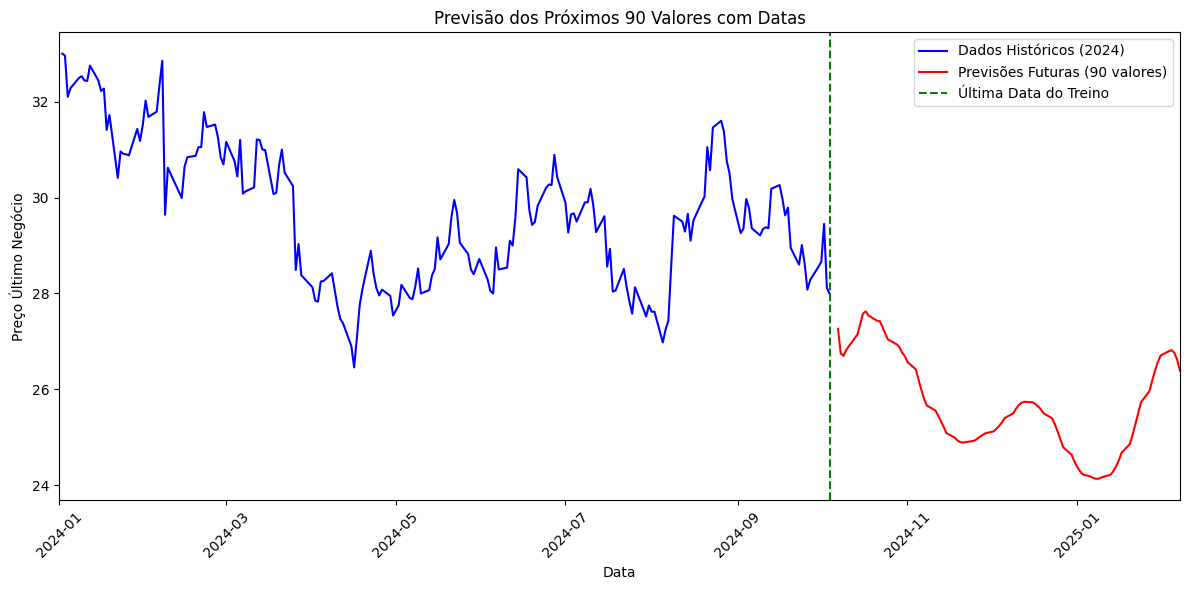

In [10]:
last_sequence = train_values[-sequence_length:]
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(90):
    next_prediction = best_model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

future_predictions = np.array(future_predictions).flatten()

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='B')

future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

plt.figure(figsize=(12, 6))

data_2024 = data[data.index >= '2024']

plt.plot(data_2024.index, data_2024['preco_ultimo_negocio'], label='Dados Históricos (2024)', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (90 valores)', color='red')

plt.xlim(pd.Timestamp('2024-01-01'), future_df['Date'].max())

plt.title('Previsão dos Próximos 90 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()